In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

<h2>Creating tensors - Grayscale</h2>

In [20]:
classification_targets = ['museum-indoor', 'museum-outdoor']
# Set device
# device = 'cuda'
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Parameters
batch_size = 64

# Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Load dataset
dataset = datasets.ImageFolder(root='../Museum_Training/Training', transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


# Create DataLoader for training and testing with batch_size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

<h2>CNN model 2</h2>

In [21]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 2)  # binary classification

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = DeepCNN().to(device)

<h2>Train and Validation</h2>

In [ ]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 15

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy


# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(test_loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    return epoch_loss, accuracy

In [17]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_accuracy:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Acc: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model1grey.pth')

print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Epoch 1/15, Train Loss: 1.1587, Train Acc: 0.5915, Val Loss: 0.6075, Val Acc: 0.6600
Epoch 2/15, Train Loss: 0.6160, Train Acc: 0.6508, Val Loss: 0.6003, Val Acc: 0.6645
Epoch 3/15, Train Loss: 0.6010, Train Acc: 0.6661, Val Loss: 0.5612, Val Acc: 0.7165
Epoch 4/15, Train Loss: 0.5856, Train Acc: 0.6970, Val Loss: 0.5867, Val Acc: 0.7080
Epoch 5/15, Train Loss: 0.5777, Train Acc: 0.7040, Val Loss: 0.5517, Val Acc: 0.7240
Epoch 6/15, Train Loss: 0.5672, Train Acc: 0.7198, Val Loss: 0.5317, Val Acc: 0.7535
Epoch 7/15, Train Loss: 0.5518, Train Acc: 0.7280, Val Loss: 0.5289, Val Acc: 0.7295
Epoch 8/15, Train Loss: 0.5537, Train Acc: 0.7246, Val Loss: 0.4955, Val Acc: 0.7685
Epoch 9/15, Train Loss: 0.5327, Train Acc: 0.7375, Val Loss: 0.4904, Val Acc: 0.7660
Epoch 10/15, Train Loss: 0.4992, Train Acc: 0.7630, Val Loss: 0.7526, Val Acc: 0.6820
Epoch 11/15, Train Loss: 0.5048, Train Acc: 0.7640, Val Loss: 0.4423, Val Acc: 0.7930
Epoch 12/15, Train Loss: 0.4876, Train Acc: 0.7695, Val Loss: 0

<h2>Loss Curve</h2>

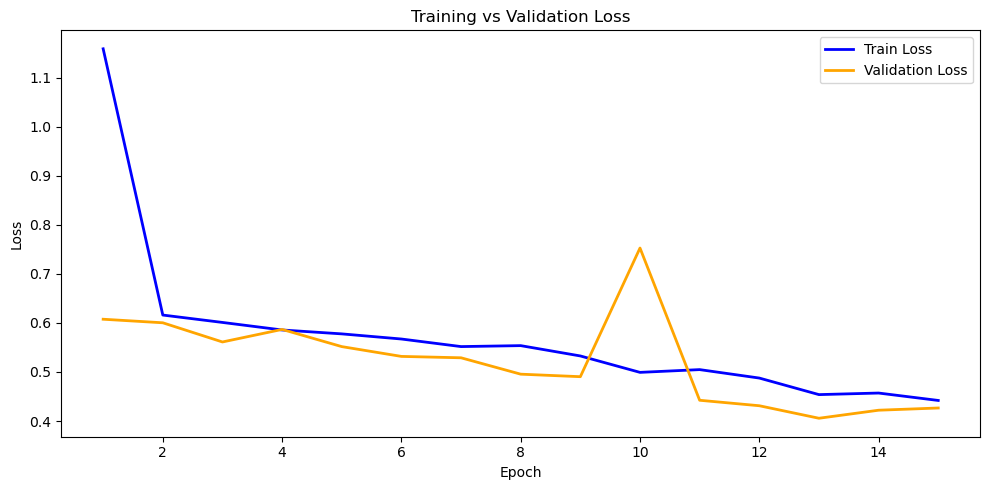

In [ ]:
# import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Train Loss', color='blue', linewidth=2)
plt.plot(epochs, val_losses, label='Validation Loss', color='orange', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

<h2>Accuracy Curve</h2>

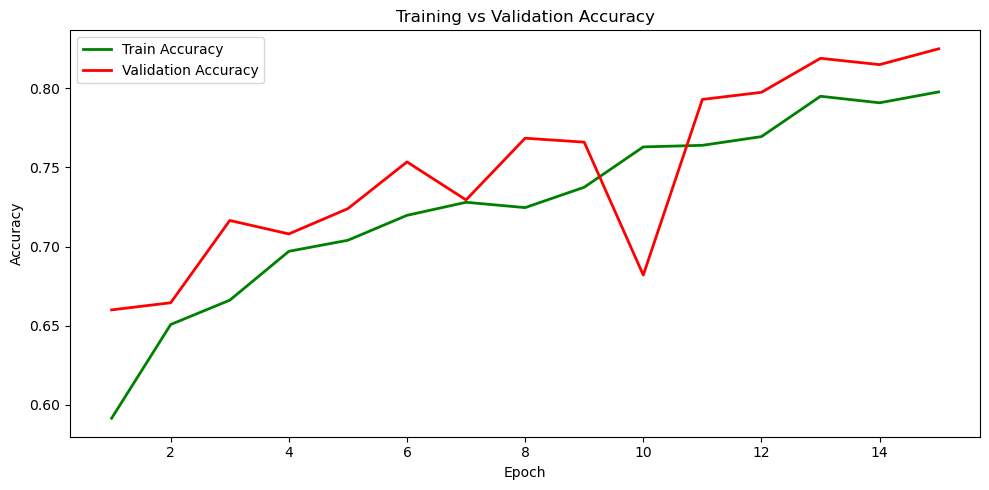

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Train Accuracy', color='green', linewidth=2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.show()

<h2>Model Test</h2>

In [22]:

# Parameters
batch_size = 64

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
test_dataset = datasets.ImageFolder(root='../Museum_Test/Museum_Validation', transform=test_transform)

test_data = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [23]:
# Load the best model
model.load_state_dict(torch.load('best_model1grey.pth'))
model.to(device)


def eval_model(model, test_data, device):
    model.eval()
    all_preds = []
    with torch.no_grad():
        for images, _ in test_data:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
    return all_preds

# Predict on the test set
test_preds = eval_model(model, test_data, device)

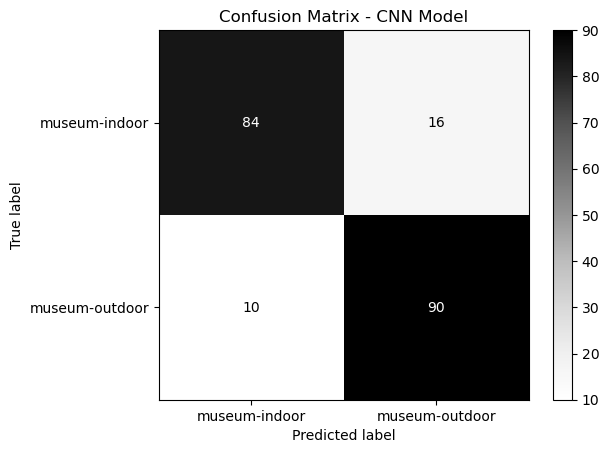

Accuracy: 0.87
Classification Report:
                 precision    recall  f1-score   support

 museum-indoor       0.89      0.84      0.87       100
museum-outdoor       0.85      0.90      0.87       100

      accuracy                           0.87       200
     macro avg       0.87      0.87      0.87       200
  weighted avg       0.87      0.87      0.87       200



In [24]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
y_test_labels = [label for _, label in test_dataset]
cm = confusion_matrix(y_test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap=plt.cm.Greys)
plt.title("Confusion Matrix - CNN Model")
plt.show()

accuracy = accuracy_score(y_test_labels, test_preds)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test_labels, test_preds, target_names=classification_targets))

<h2>Single Image Test</h2>

In [25]:
# Function to predict on a single image
def predict_image(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).cpu().numpy()[0]
    return dataset.classes[pred]


image_path = '../Museum_Test/Museum_Validation/museum-indoor/Places365_val_00000665.jpg'
single_pred = predict_image(model, image_path, transform, device)
print(f"Predicted class: {single_pred}")

Predicted class: museum-indoor


In [26]:
# Function to predict on a single image
def predict_image(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).cpu().numpy()[0]
    return dataset.classes[pred]

# Predict on a single image
image_path = '../Museum_Test/Museum_Validation/museum-outdoor/Places365_val_00001310.jpg'
single_pred = predict_image(model, image_path, transform, device)
print(f"Predicted class: {single_pred}")

Predicted class: museum-outdoor


<h2>Wrong Predictions</h2>

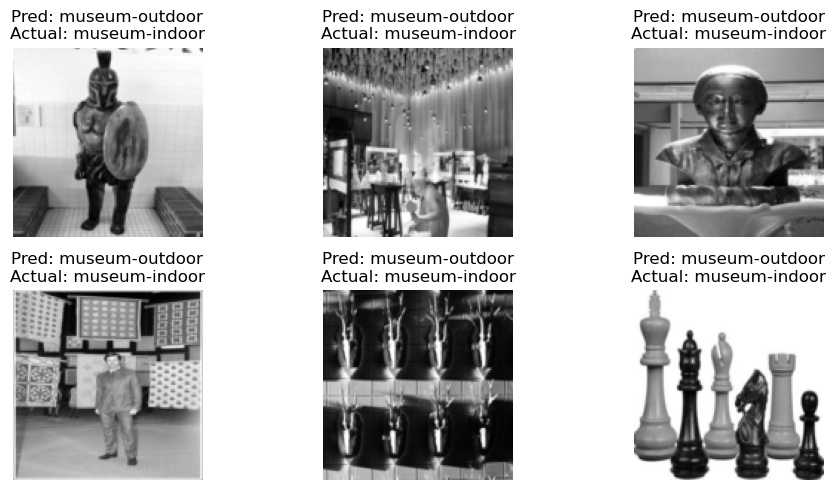

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Make sure model is in eval mode
model.eval()

wrong_predictions = []

with torch.no_grad():
    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for img, pred, true in zip(images, preds, labels):
            if pred != true:
                wrong_predictions.append((img.cpu(), pred.item(), true.item()))
            if len(wrong_predictions) >= 6:
                break
        if len(wrong_predictions) >= 6:
            break

# Plot 6 wrong predictions in 2x3 grid
fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for i, (img, pred, true) in enumerate(wrong_predictions):
    ax = axes[i // 3, i % 3]

    
    img_np = img.squeeze(0).numpy()  
    img_np = img_np * 0.5 + 0.5       
    img_np = np.clip(img_np, 0, 1)

    ax.imshow(img_np, cmap='gray')
    ax.set_title(f"Pred: {test_dataset.classes[pred]}\nActual: {test_dataset.classes[true]}")
    ax.axis('off')


for j in range(len(wrong_predictions), 6):
    axes[j // 3, j % 3].axis('off')

plt.tight_layout()
plt.show()
